In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
import matplotlib.pyplot as plt
import shap

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "text.usetex": False,              # Usa True si tienes LaTeX instalado
    "font.family": "serif",            # Usa tipografía tipo LaTeX
    "font.serif": ["Times New Roman"], # O usa "Computer Modern Roman", "Palatino", etc.
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 150,
    "figure.figsize": (6, 2.5),        # En la misma línea
    "savefig.bbox": "tight"
})

# --- 1. Tamaño y resolución de figuras ---
plt.rcParams['figure.figsize'] = (6, 4)  # Tamaño base de figuras
plt.rcParams['figure.dpi'] = 300         # Alta resolución para publicaciones

# --- 2. Fuente tipo LaTeX ---
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# --- 3. Estilo elegante y minimalista ---
sns.set_theme(style="white", palette="viridis", font_scale=1.2)


# Dark green to black:
DG_to_Bl = sns.color_palette("dark:#5A9_r") #, as_cmap=True)
# Grey blue to bone:
GB_to_Bo = sns.color_palette("blend:#7AB,#EDA") #, as_cmap=True)


# Elegante y visible
sns.set_palette(DG_to_Bl)



# Alternativas:
# sns.set_palette("Set2")
# sns.set_palette("coolwarm")
# sns.set_palette("crest")  # para categorías suaves

In [2]:
def plot_graphs(n=1, plot_type='curve'):
    """
    Dibuja n gráficas en fila horizontal, con aspect ratio cuadrado y fuentes estilo LaTeX.
    
    Parámetros:
    - n: int, número de gráficas
    - plot_type: 'curve' o 'image'
    """
    # Estilo LaTeX y fuente legible
    plt.rcParams.update({
        "text.usetex": False,
        "font.size": 14,
        "font.family": "serif",
        "axes.titlesize": 16,
        "axes.labelsize": 14
    })

    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5), constrained_layout=True)

    if n == 1:
        axs = [axs]  # convierte en lista para tratamiento uniforme

    for i, ax in enumerate(axs):
        if plot_type == 'curve':
            x = np.linspace(0, 2 * np.pi, 100)
            y = np.sin(x + i)
            ax.plot(x, y, label=fr"$\sin(x + {i})$")
            ax.set_title(fr"Curva {i+1}")
            ax.set_xlabel(r"$x$")
            ax.set_ylabel(r"$y$")
            ax.legend()
        elif plot_type == 'image':
            data = np.random.rand(10, 10)
            im = ax.imshow(data, cmap='viridis', origin='lower')
            ax.set_title(fr"Imagen {i+1}")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        ax.set_aspect('equal')  # aspect ratio cuadrado

    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   M_s                1000 non-null   float64
 1   A_ex               1000 non-null   float64
 2   K_u                1000 non-null   int64  
 3   alpha              1000 non-null   float64
 4   angle_theta        1000 non-null   float64
 5   angle_phi          1000 non-null   float64
 6   Transmission       1000 non-null   float64
 7   Phase Shift (deg)  1000 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 62.6 KB
None
                 M_s          A_ex     K_u        alpha  angle_theta  \
count    1000.000000  1.000000e+03  1000.0  1000.000000  1000.000000   
mean    72646.444567  4.000000e-12     0.0     0.015490    45.009230   
std     28001.224414  8.081978e-28     0.0     0.003178    26.008575   
min     24250.156001  4.000000e-12     0.0     0.010000     0.010314   

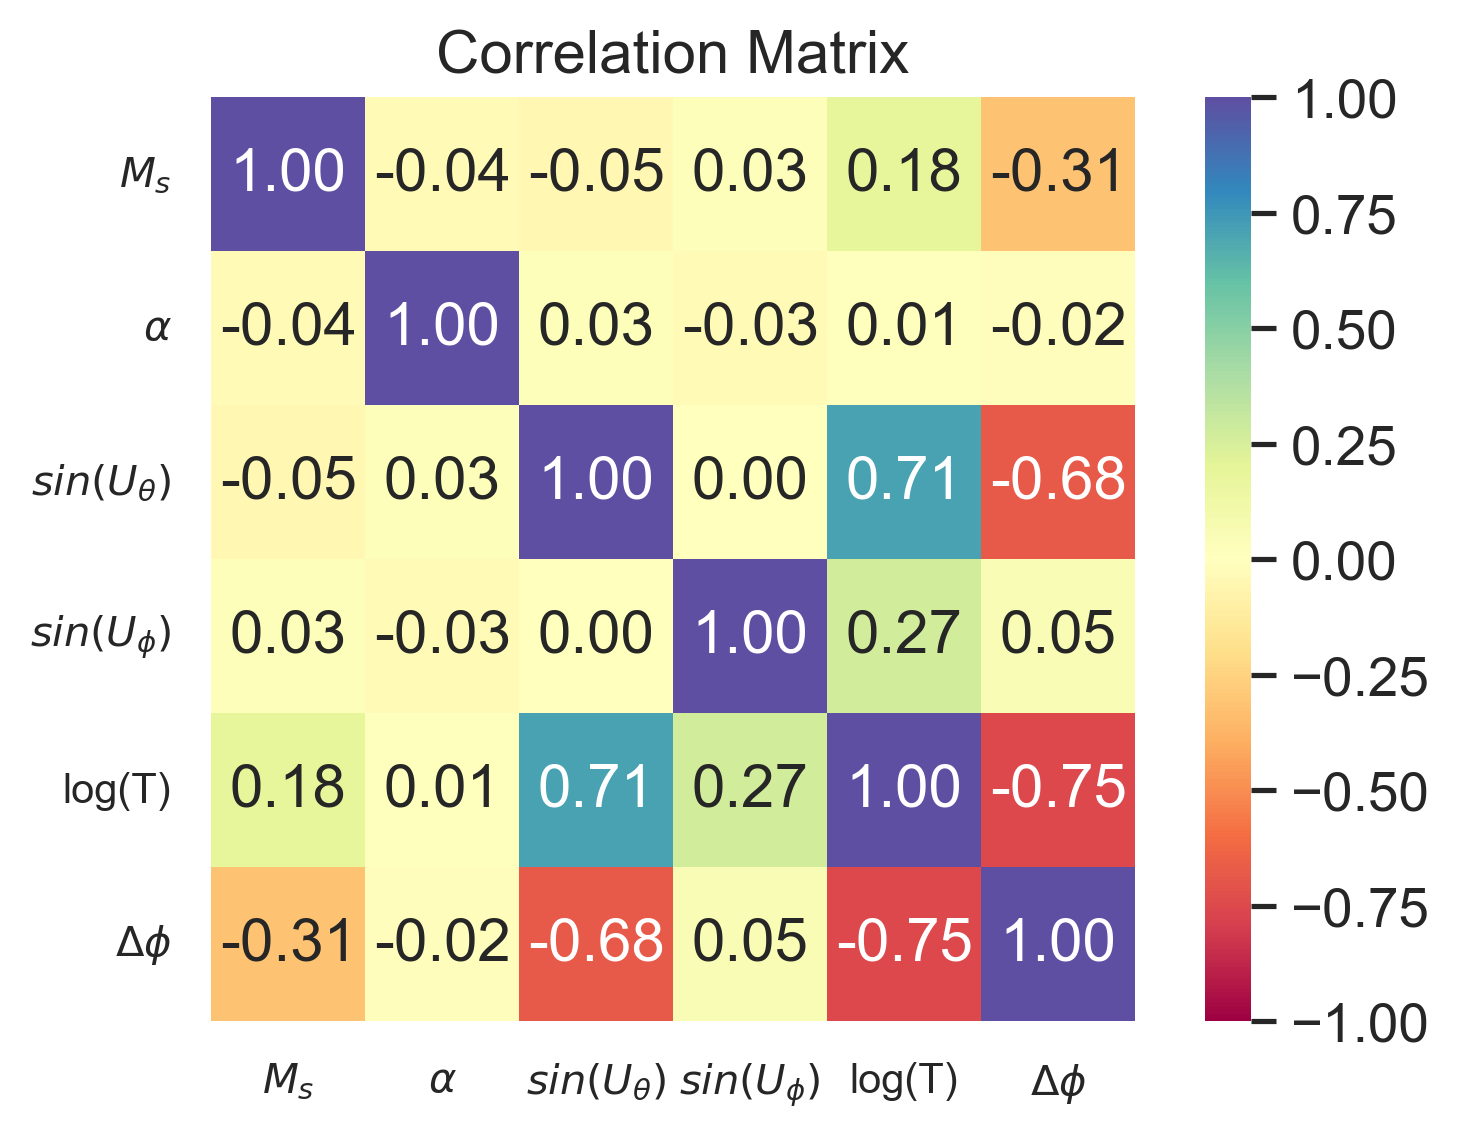

In [3]:
# Load dataset
#df = pd.read_csv("D:\\UBERMAG_RESULTS\\spin_wave_results-two-bounds-lhs-1000.csv")  # Update with the actual filename
df = pd.read_csv("D:\\UBERMAG_RESULTS\\spin_wave_results_LHS_1000_LG2um.csv")  # Update with the actual filename 

# Check basic stats
print(df.info())
print(df.describe())


# Discard raow where T > 1 and TRANSFORM DATA: normalised to the maximum T (i.e. max Ms and lowest alpha)

df = df[df["Transmission"] <= 0.99]
print(np.max(df["Transmission"]))
#df["Transmission"] = df["Transmission"] / np.max(df["Transmission"])

# Transform Phase Shift.


phases_rad = np.deg2rad(df["Phase Shift (deg)"])
mean_phase = np.angle(np.mean(np.exp(1j * phases_rad)))
centered_phases_rad = np.angle(np.exp(1j * (phases_rad - mean_phase)))
df["Phase Shift (deg)"] = np.rad2deg(centered_phases_rad) + 180


# TRANSFORM angle_u to sin(angle_u)


df["angle_theta"] = np.sin(df["angle_theta"] * np.pi / 180)
df.rename(columns={"angle_theta": r"$sin(U_\theta)$"}, inplace=True)

df["angle_phi"] = np.sin(df["angle_phi"] * np.pi / 180)
df.rename(columns={"angle_phi": r"$sin(U_\phi)$"}, inplace=True)

df["Transmission"] = np.log(df["Transmission"])
df.rename(columns={"Transmission": "log(T)"}, inplace=True)

df.rename(columns={"Phase Shift (deg)": r"$\Delta \phi$"}, inplace=True)
df.rename(columns={"M_s": r"$M_s$"}, inplace=True)
df.rename(columns={"alpha": r"$\alpha$"}, inplace=True)

df = df.drop(columns=['A_ex', 'K_u'])
df = df.drop_duplicates()

# df["Phase Shift (deg)"] = np.log(df["Phase Shift (deg)"])
# df.rename(columns={"Phase Shift (deg)": "log(Phase Shift (deg))"}, inplace=True)

# Check basic stats
print(df.info())
print(df.describe())


# Check correlation matrix

fig, ax = plt.subplots(ncols=1, sharey=True)

# plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="Spectral", vmin=-1.00, vmax=1.00, fmt=".2f")
ax.set_box_aspect(1)  # Makes the plot square
ax.tick_params(axis='both', labelsize=10)
plt.title("Correlation Matrix")
plt.show()


In [4]:
seed = 33

# ===========================
# 📥 1. Cargar y preparar datos
# ===========================
# df = pd.read_excel("tu_archivo.xlsx")  # <-- Carga tu archivo real aquí

# Definir variables de entrada y salida
X = df.drop(columns=["log(T)", r"$\Delta \phi$", r"$\alpha$"])
y_T = df["log(T)"]
y_P = df[r"$\Delta \phi$"]

# Dividir en train/test
X_train, X_test, y_T_train, y_T_test, y_P_train, y_P_test = train_test_split(
    X, y_T, y_P, test_size=0.2, random_state=seed
)

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # ajusta y aplica la transformación.
X_test_scaled = scaler.transform(X_test) # solo aplica, usando la media y varianza de X_train

In [5]:

param_grid = {
    'hidden_layer_sizes': [
        (10,), (20,), (30,), 
        (20, 10), (30, 10), 
        (30, 15, 5)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01],
}

mlp = MLPRegressor(
    max_iter=3000,
    solver='adam',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=seed)
grid_T = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_T.fit(X_train_scaled, y_T_train)
print(grid_T.best_estimator_.n_iter_)  # Number of iterations used

mlp = MLPRegressor(
    max_iter=3000,
    solver='adam',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=seed)
grid_P = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_P.fit(X_train_scaled, y_P_train)
print(grid_P.best_estimator_.n_iter_)  # Number of iterations used


Fitting 5 folds for each of 96 candidates, totalling 480 fits
478
Fitting 5 folds for each of 96 candidates, totalling 480 fits
980


In [6]:
best_NN_T = grid_T.best_params_
print("Best params:", best_NN_T)

best_NN_P = grid_P.best_params_
print("Best params:", best_NN_P)


Best params: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (30, 10), 'learning_rate_init': 0.01}
Best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 15, 5), 'learning_rate_init': 0.001}


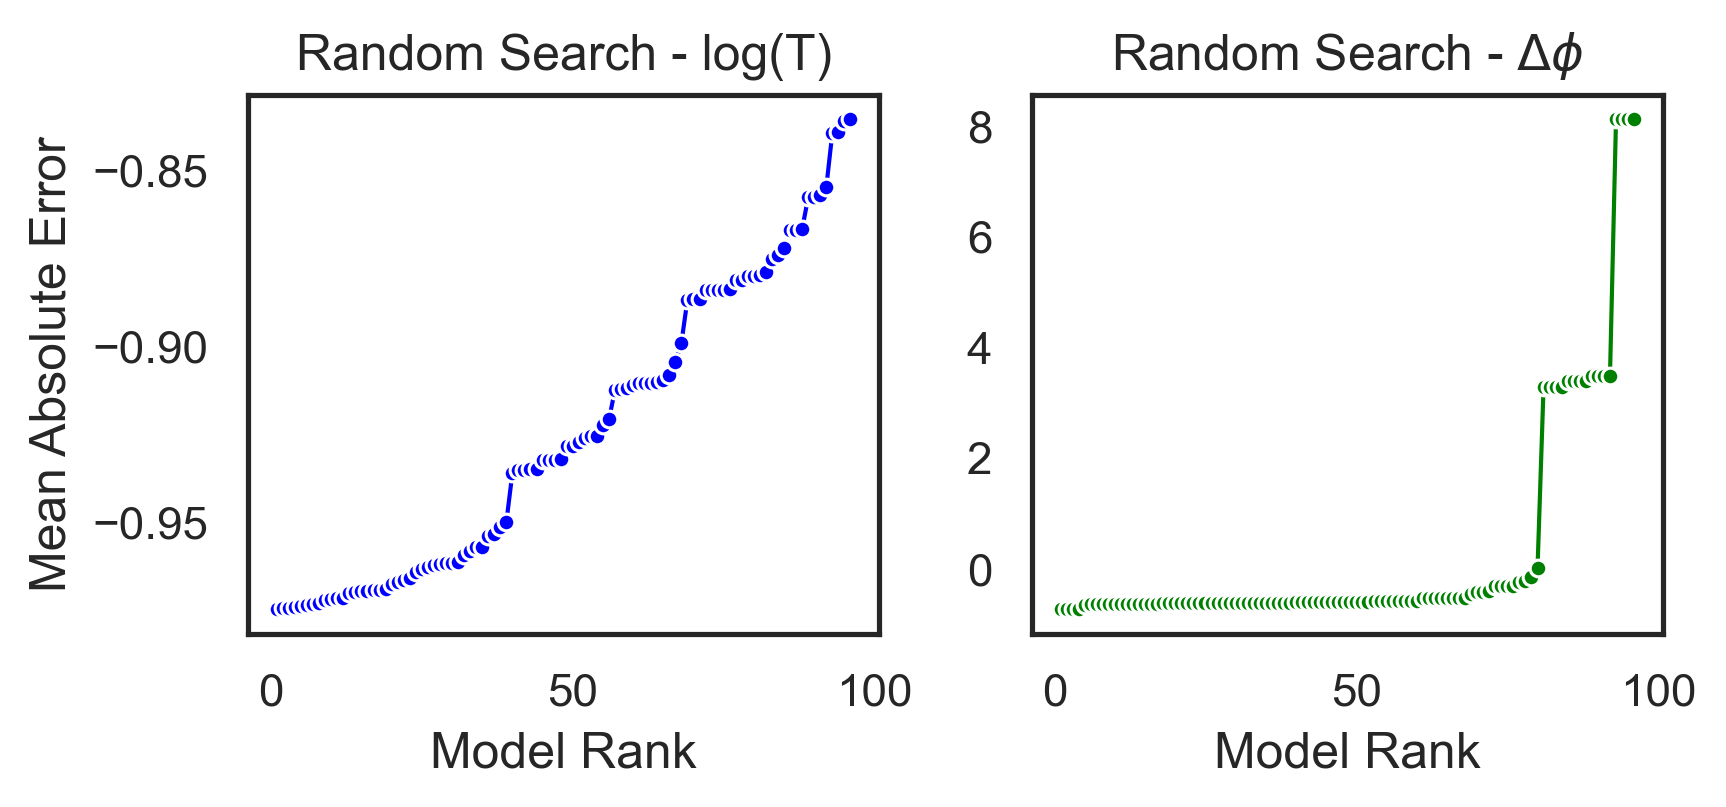

In [7]:

# Extract results
results_T = pd.DataFrame(grid_T.cv_results_)
results_P = pd.DataFrame(grid_P.cv_results_)

# Sort by model performance rank
results_T_sorted = results_T.sort_values("rank_test_score")
results_P_sorted = results_P.sort_values("rank_test_score")

# Set style
sns.set(style="white", font_scale=1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(6,3), sharey=False)

# Transmission model
sns.lineplot(
    ax=axes[0],
    x=range(1, len(results_T_sorted) + 1),
    y=-results_T_sorted["mean_test_score"],
    marker="o",
    markersize=4,    
    linewidth=1,
    color="blue"
)
axes[0].set_title("Random Search - log(T)")
axes[0].set_xlabel("Model Rank")
axes[0].set_ylabel("R2")

# Phase Shift model
sns.lineplot(
    ax=axes[1],
    x=range(1, len(results_P_sorted) + 1),
    y=-results_P_sorted["mean_test_score"],
    marker="o",
    markersize=4,
    linewidth=1,
    color="green"
)
axes[1].set_title(r"Random Search - $\Delta\phi$")
axes[1].set_xlabel("Model Rank")
axes[1].set_ylabel("")

# Final formatting
#plt.suptitle("Hyperparameter Tuning Results (MAE vs. Rank)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("Tuning_NN_ranked_models.pdf", format='pdf')
plt.show()

In [12]:


# ===============================
# 🔮 2. Modelo para Transmission
# ===============================
mlp_T = MLPRegressor(hidden_layer_sizes=(30,10), 
                     activation='tanh',
                     alpha=0.01,
                     solver='adam',
                     max_iter=5000, 
                     learning_rate_init=0.01,
                     random_state=seed,
                     early_stopping=True)
mlp_T.fit(X_train_scaled, y_T_train)
y_pred_T = mlp_T.predict(X_test_scaled)

r2_T = r2_score(y_T_test, y_pred_T)
print(f"R² log(Transmission): {r2_T:.3f}")

# ===============================
# 🔮 3. Modelo para Phase Shift
# (añadiendo log(Transmission) como input)
# ===============================

mlp_P = MLPRegressor(hidden_layer_sizes=(30,15,5),
                        activation='relu',
                        alpha=0.0001,
                        solver='adam',
                        max_iter=5000,
                        learning_rate_init=0.005,
                        early_stopping=True,
                        validation_fraction=0.1,
                        n_iter_no_change=20,
                        random_state=seed)
mlp_P.fit(X_train_scaled, y_P_train)
y_pred_P = mlp_P.predict(X_test_scaled)

r2_P = r2_score(y_P_test, y_pred_P)
print(f"R² Phase Shift: {r2_P:.3f}")

# ========================
# 📊 4. Visualizar predicciones
# ========================
def plot_prediction(y_true, y_pred, title):
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_prediction(y_T_test, y_pred_T, f"Prediction vs Actual - log(Transmission) ($R^2$ = {r2_T:.2f})")
#plot_prediction(y_P_test, y_pred_P, f"Prediction vs Actual - Phase Shift ($R^2$ = {r2_P:.2f})")




R² log(Transmission): 0.942
R² Phase Shift: 0.895


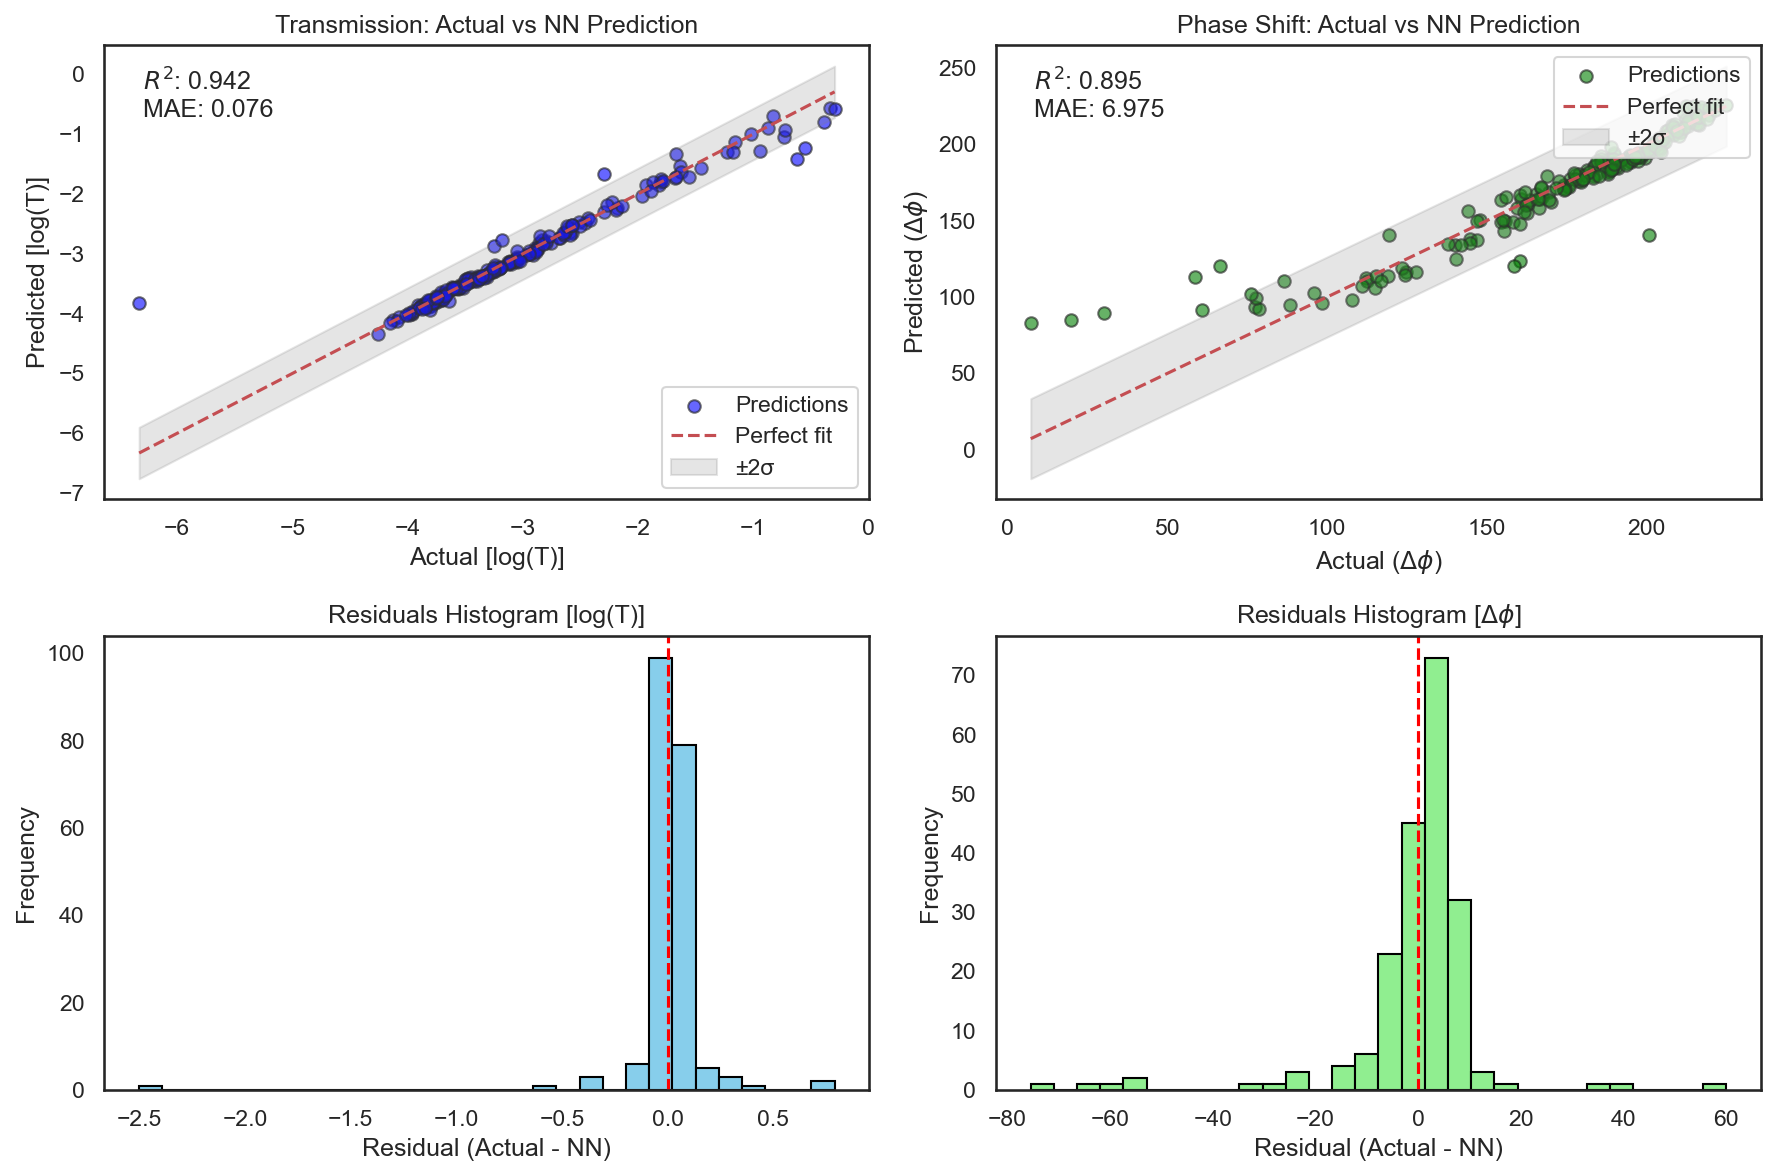

In [34]:

mae_T = mean_absolute_error(y_T_test, y_pred_T)
mae_P = mean_absolute_error(y_P_test, y_pred_P)


# === Calculate Residuals ===
residuals_T = y_T_test - y_pred_T
residuals_P = y_P_test - y_pred_P

std_T = np.std(residuals_T)
std_P = np.std(residuals_P)

# === Metrics ===
r2_T = r2_score(y_T_test, y_pred_T)
mae_T = mean_absolute_error(y_T_test, y_pred_T)

r2_P = r2_score(y_P_test, y_pred_P)
mae_P = mean_absolute_error(y_P_test, y_pred_P)

# === Create Figure ===
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=150)

# === Plot 1a: Scatter + PI for Transmission ===
axs[0, 0].scatter(y_T_test, y_pred_T, alpha=0.6, edgecolor='k', color='blue', label="Predictions")
line_T = np.linspace(y_T_test.min(), y_T_test.max(), 100)
axs[0, 0].plot(line_T, line_T, 'r--', label="Perfect fit")
axs[0, 0].fill_between(line_T, line_T - 2*std_T, line_T + 2*std_T, color='gray', alpha=0.2, label="±2σ")

axs[0, 0].set_title("Transmission: Actual vs NN Prediction")
axs[0, 0].set_xlabel("Actual [log(T)]")
axs[0, 0].set_ylabel("Predicted [log(T)]")
axs[0, 0].legend()
axs[0, 0].text(
    0.05, 0.95,
    f"$R^2$: {r2_T:.3f}\nMAE: {mae_T:.3f}",
    transform=axs[0, 0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 1b: Residuals Histogram for Transmission ===
axs[1, 0].hist(residuals_T, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].axvline(0, color='red', linestyle='--')
axs[1, 0].set_title("Residuals Histogram [log(T)]")
axs[1, 0].set_xlabel("Residual (Actual - NN)")
axs[1, 0].set_ylabel("Frequency")

# === Plot 2a: Scatter + PI for Phase Shift ===
axs[0, 1].scatter(y_P_test, y_pred_P, alpha=0.6, edgecolor='k', color='green', label="Predictions")
line_P = np.linspace(y_P_test.min(), y_P_test.max(), 100)
axs[0, 1].plot(line_P, line_P, 'r--', label="Perfect fit")
axs[0, 1].fill_between(line_P, line_P - 2*std_P, line_P + 2*std_P, color='gray', alpha=0.2, label="±2σ")

axs[0, 1].set_title("Phase Shift: Actual vs NN Prediction")
axs[0, 1].set_xlabel(r"Actual ($\Delta\phi$)")
axs[0, 1].set_ylabel(r"Predicted ($\Delta\phi$)")
axs[0, 1].legend(loc='upper right')
axs[0, 1].text(
    0.05, 0.95,
    f"$R^2$: {r2_P:.3f}\nMAE: {mae_P:.3f}",
    transform=axs[0, 1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 2b: Residuals Histogram for Phase Shift ===
axs[1, 1].hist(residuals_P, bins=30, color='lightgreen', edgecolor='black')
axs[1, 1].axvline(0, color='red', linestyle='--')
axs[1, 1].set_title(r"Residuals Histogram [$\Delta\phi$]")
axs[1, 1].set_xlabel("Residual (Actual - NN)")
axs[1, 1].set_ylabel("Frequency")

# === Final Layout ===
plt.tight_layout()
plt.savefig("nn_actual_vs_pred_with_residuals.pdf", format='pdf')
plt.show()

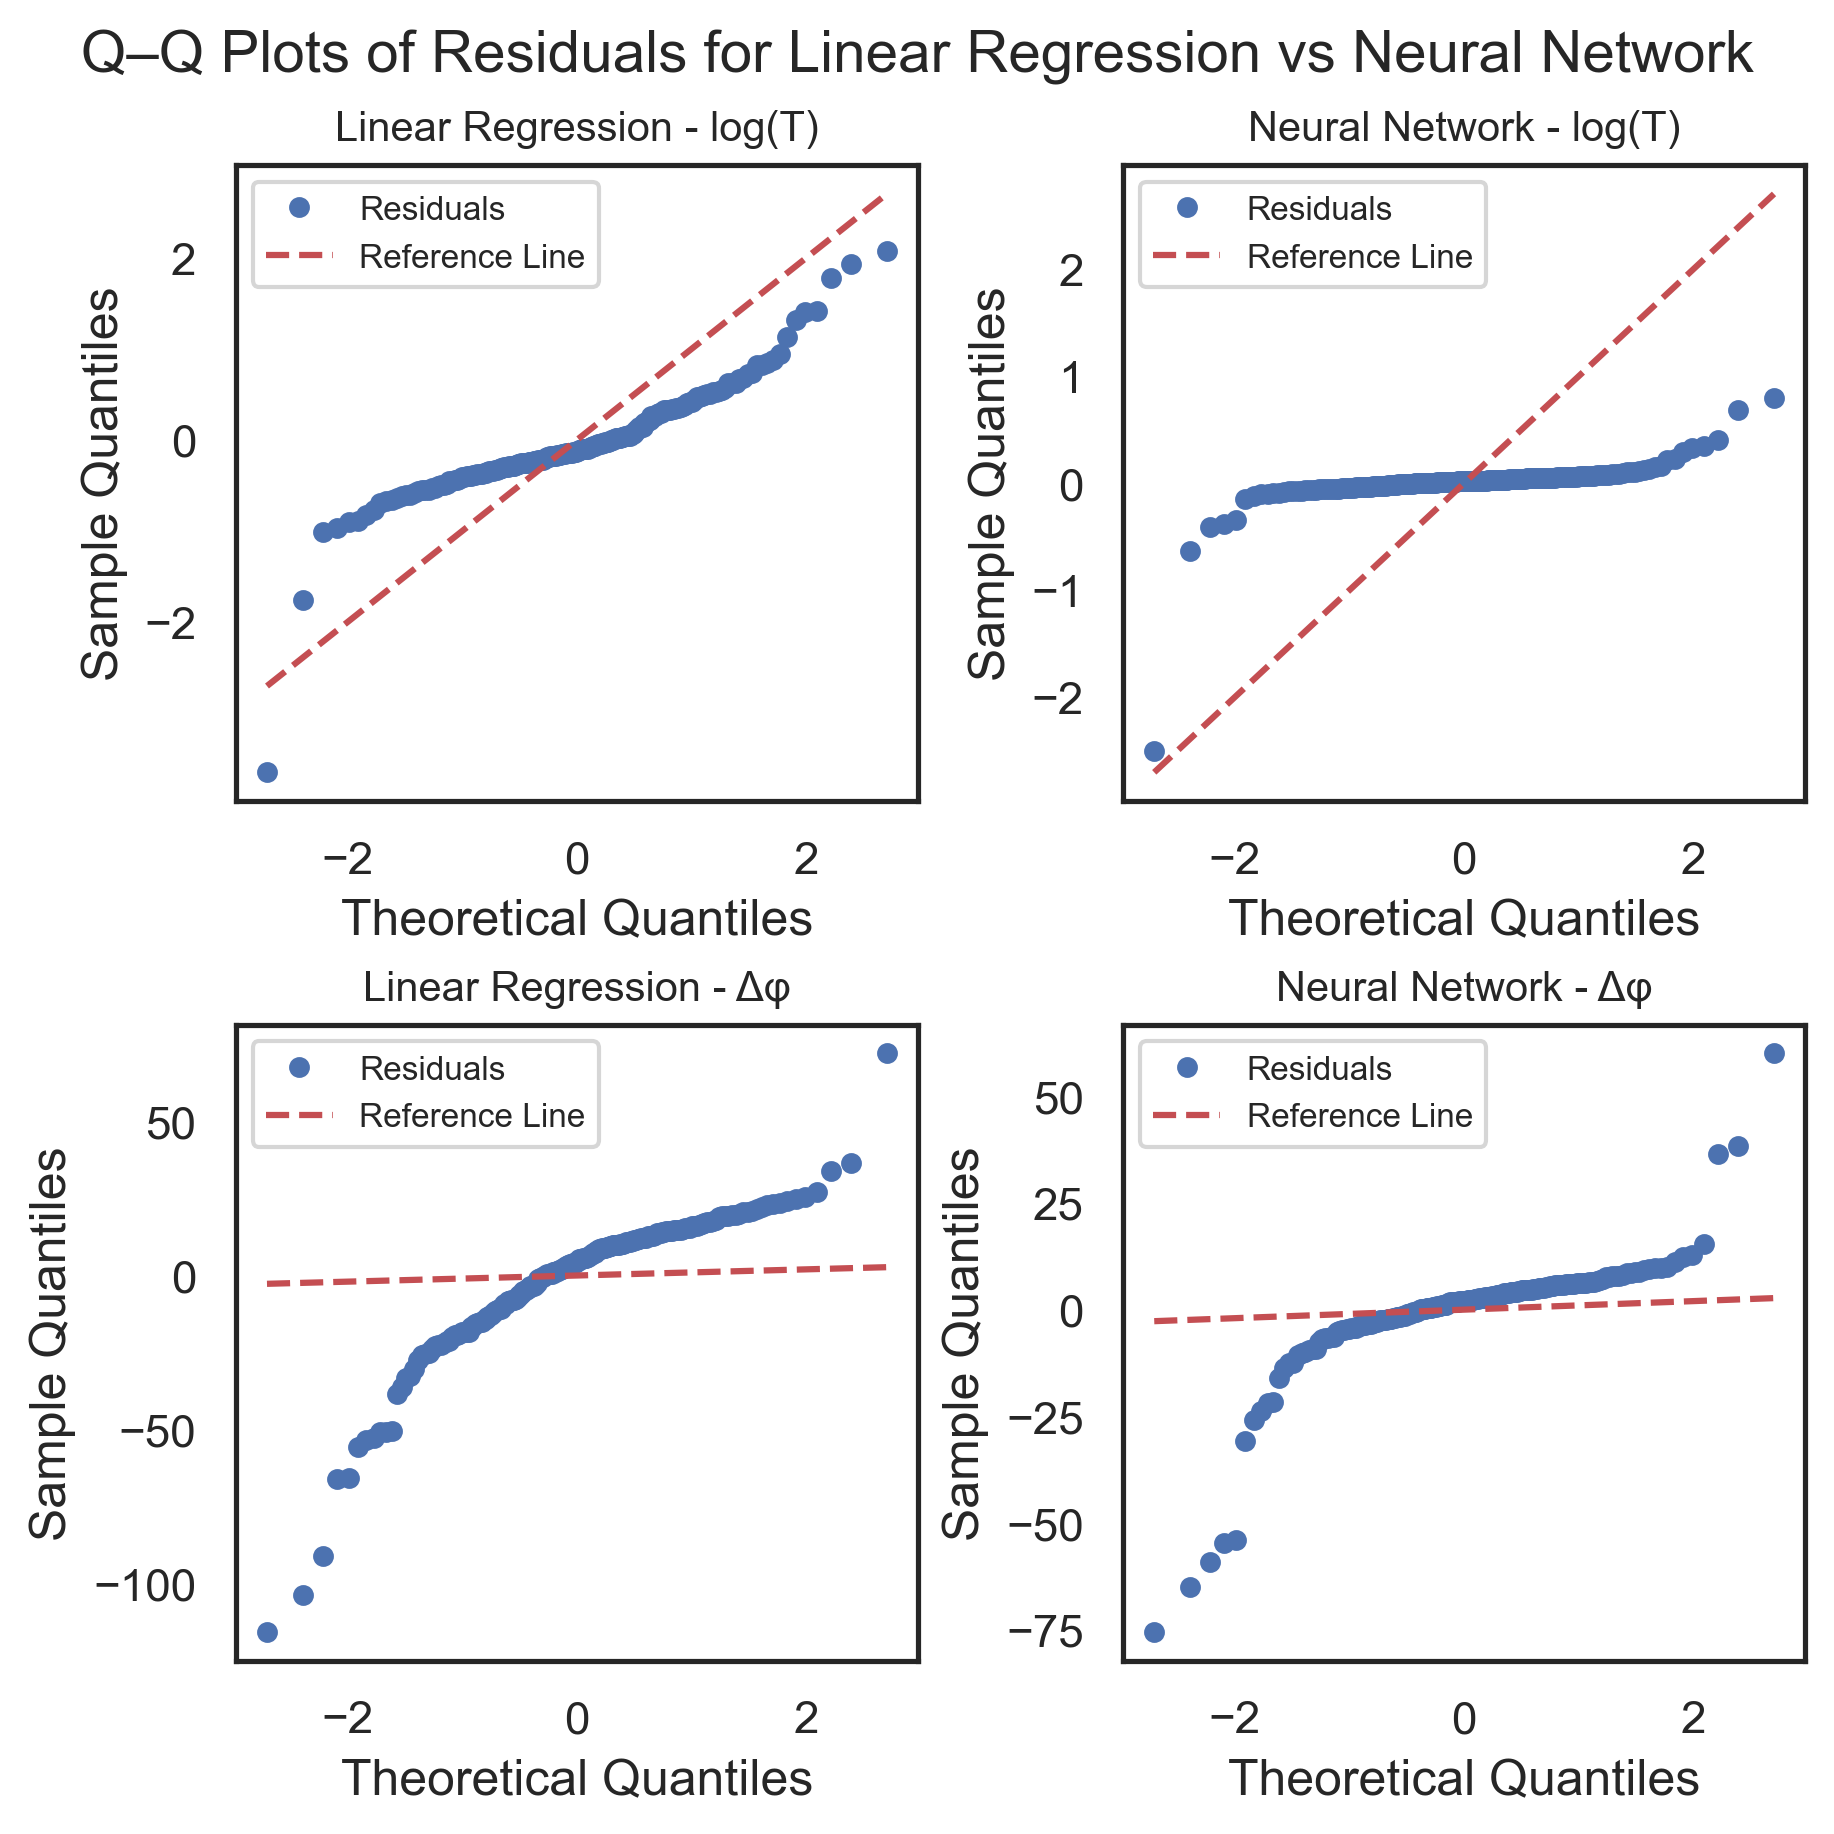

In [36]:
import statsmodels.api as sm
import scipy.stats as stats
# === Fit linear regression models for comparison ===
lin_T = LinearRegression().fit(X_train, y_T_train)
lin_P = LinearRegression().fit(X_train, y_P_train)

# Predictions & residuals
y_pred_lin_T = lin_T.predict(X_test)
y_pred_lin_P = lin_P.predict(X_test)

residuals_lin_T = y_T_test - y_pred_lin_T
residuals_lin_P = y_P_test - y_pred_lin_P

residuals_NN_T = y_T_test - y_pred_T
residuals_NN_P = y_P_test - y_pred_P

# ============================================================
# Compute residuals for each model
# ============================================================
residuals = {
    "Linear Regression - log(T)": y_T_test - y_pred_lin_T,
    "Neural Network - log(T)": y_T_test - y_pred_T,
    "Linear Regression - Δφ": y_P_test - y_pred_lin_P,
    "Neural Network - Δφ": y_P_test - y_pred_P
}

# ============================================================
# Plot QQ plots in 2x2 grid
# ============================================================
fig, axs = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True, sharey=False)
fig.suptitle(r"Q–Q Plots of Residuals for Linear Regression vs Neural Network", fontsize=14)

for ax, (name, resid) in zip(axs.flatten(), residuals.items()):
    osm, osr = stats.probplot(resid, dist="norm")[:2]  # (theoretical, sample)
    ax.plot(osm[0], osm[1], 'o', markersize=4, label='Residuals')
    ax.plot(osm[0], osm[0], 'r--', label='Reference Line')
    ax.set_title(name, fontsize=10)
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")
    ax.grid(False)
    ax.legend(fontsize=8)

# Save and show
plt.savefig("QQ_plots_NN_vs_LR.pdf", format='pdf')
plt.show()


In [29]:
# 🔁 Predicciones sobre train y test
y_pred_T_train = mlp_T.predict(X_train_scaled)
y_pred_T_test = mlp_T.predict(X_test_scaled)

# Métricas
mae_train = mean_absolute_error(y_T_train, y_pred_T_train)
mae_test = mean_absolute_error(y_T_test, y_pred_T_test)
r2_train = r2_score(y_T_train, y_pred_T_train)
r2_test = r2_score(y_T_test, y_pred_T_test)

print(f"Train MAE T: {mae_train:.4f} | R²: {r2_train:.4f}")
print(f"Test  MAE T: {mae_test:.4f} | R²: {r2_test:.4f}")




# 🔁 Predicciones sobre train y test
y_pred_P_train = mlp_P.predict(X_train_scaled)
y_pred_P_test = mlp_P.predict(X_test_scaled)

# Métricas
mae_train = mean_absolute_error(y_P_train, y_pred_P_train)
mae_test = mean_absolute_error(y_P_test, y_pred_P_test)
r2_train = r2_score(y_P_train, y_pred_P_train)
r2_test = r2_score(y_P_test, y_pred_P_test)

print(f"Train MAE P: {mae_train:.4f} | R²: {r2_train:.4f}")
print(f"Test  MAE P: {mae_test:.4f} | R²: {r2_test:.4f}")

Train MAE T: 0.0776 | R²: 0.9770
Test  MAE T: 0.0759 | R²: 0.9425
Train MAE P: 8.4682 | R²: 0.7378
Test  MAE P: 6.9745 | R²: 0.8950


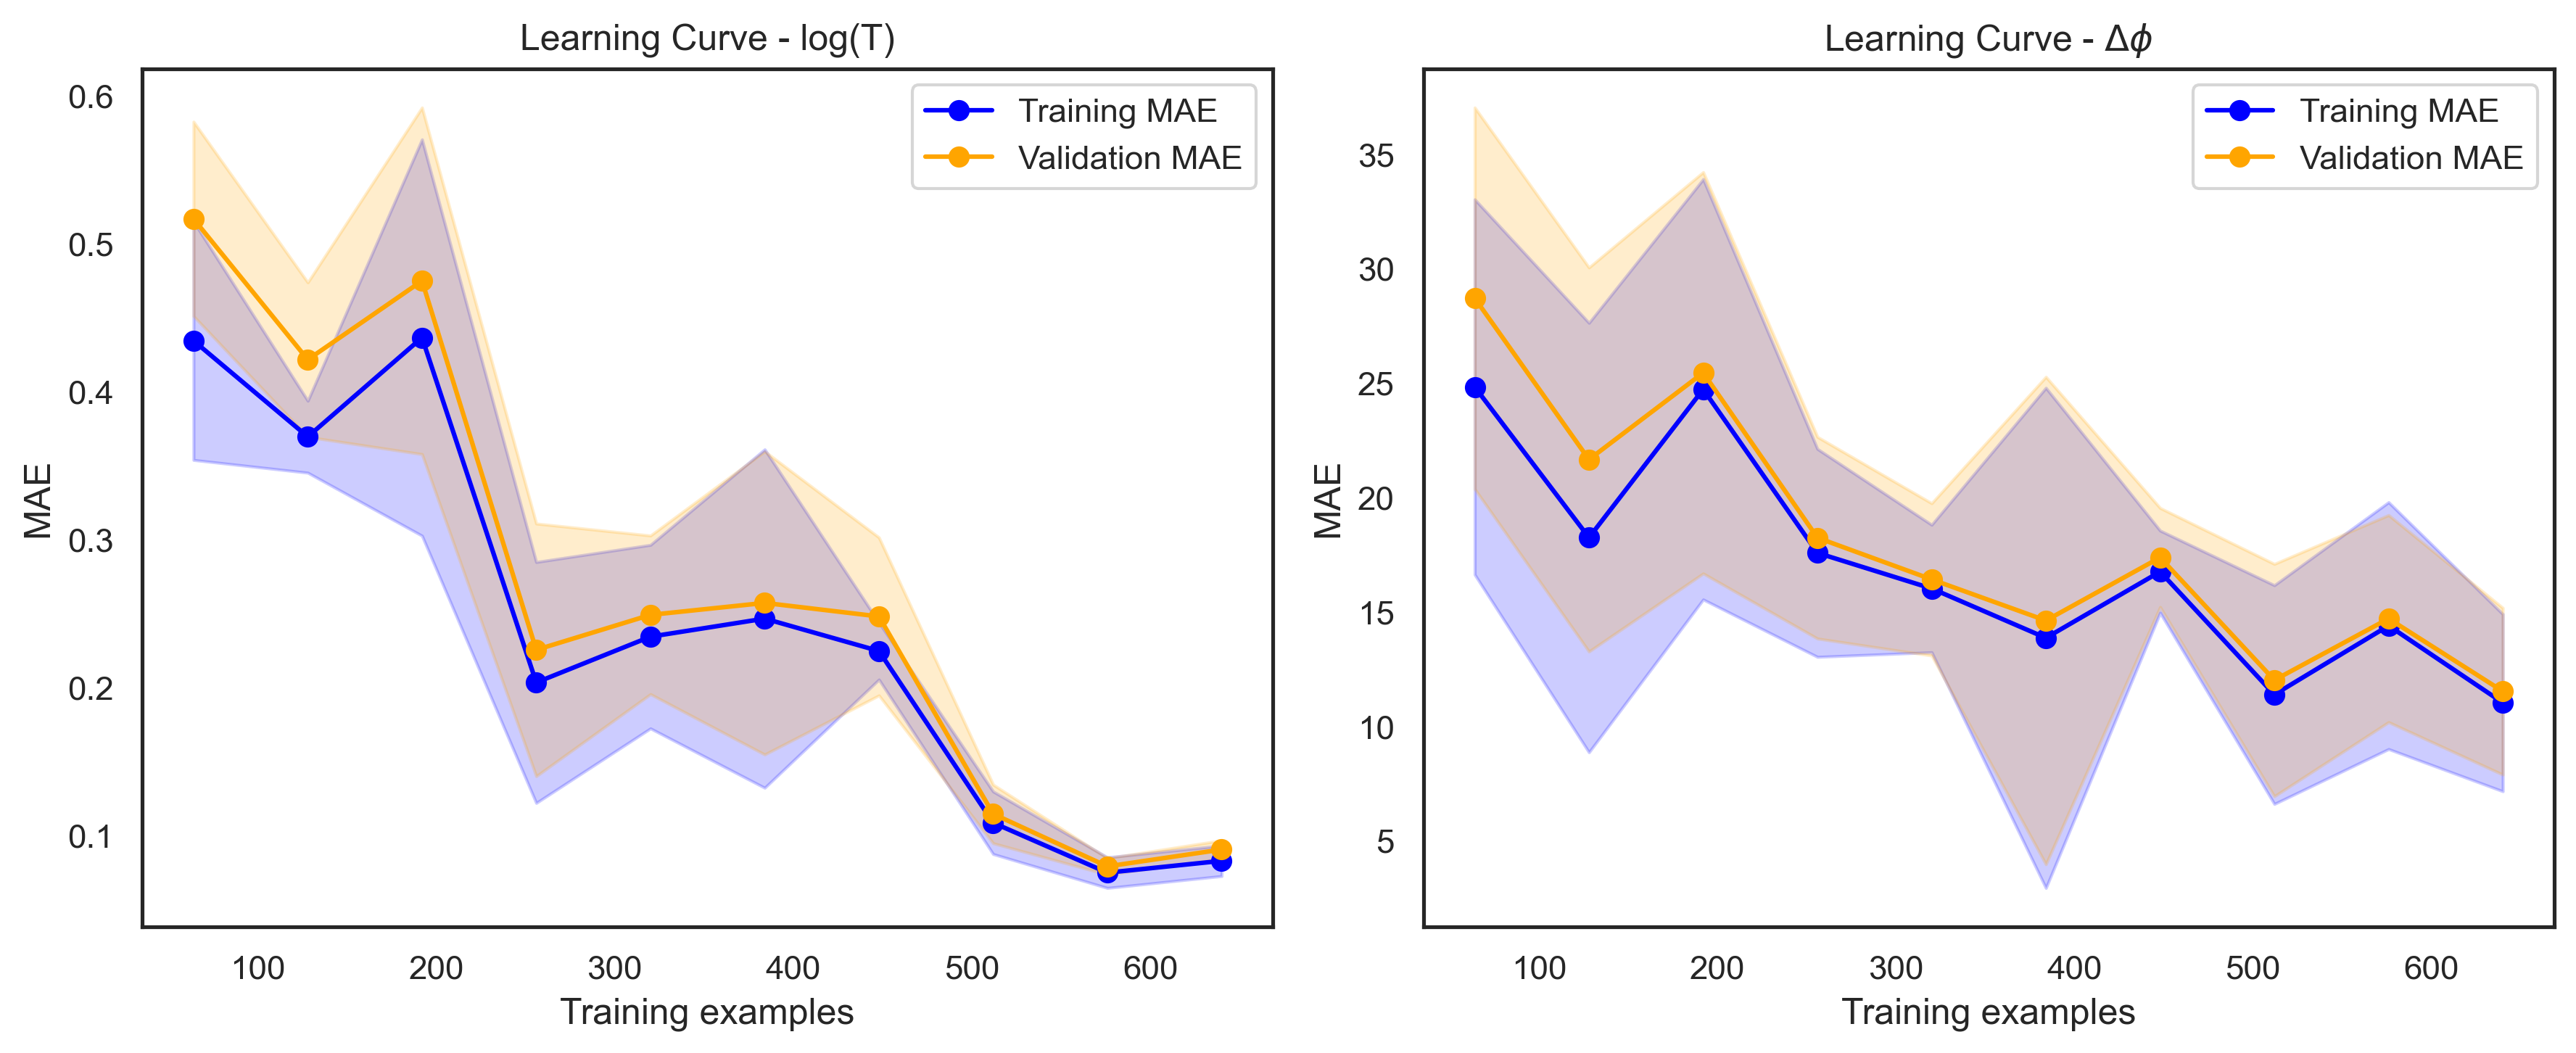

In [17]:

# === Helper function ===
def plot_learning_curve(estimator, X, y, ax, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_absolute_error', # 'neg_mean_absolute_error'
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, shuffle=True, random_state=42
    )

    # Convert negative MAE to positive
    train_scores = -train_scores
    val_scores = -val_scores

    # Mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    ax.plot(train_sizes, train_mean, 'o-', label="Training MAE", color='blue')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    ax.plot(train_sizes, val_mean, 'o-', label="Validation MAE", color='orange')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("MAE")
    ax.grid(False)
    ax.legend()

# === Create plots side by side ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_learning_curve(mlp_T, X_train_scaled, y_T_train, axs[0], "Learning Curve - log(T)")
plot_learning_curve(mlp_P, X_train_scaled, y_P_train, axs[1], r"Learning Curve - $\Delta \phi$")

plt.tight_layout()
plt.savefig("learning_curves_NN.pdf", format='pdf')
plt.show()


In [30]:
for i, (w, b) in enumerate(zip(mlp_T.coefs_, mlp_T.intercepts_)):
    print(f"Capa {i+1}:")
    print("Pesos:\n", w)
    print("Sesgos:\n", b)


Capa 1:
Pesos:
 [[ 0.22615998  0.16455786  0.03425549 -0.68029709  0.36555447 -0.20201404
  -0.12392757  0.52855695  0.11635271  0.15475075  0.51167018 -0.11510231
  -0.23953779  0.26072137 -0.18149292  0.56764352  0.24856626  0.29293862
  -0.2385496  -0.42384571  0.0828422  -0.44174112  0.04966711  0.21886901
  -0.134916   -0.47352247  0.56219772 -0.44217162  0.2446765   0.43103853]
 [ 0.65195576  0.39793036  0.22922676 -0.20063911 -0.1867656  -0.49096193
  -0.38513169 -0.69386811  0.04139516  0.51176316  0.36217439 -0.1194288
   0.66602531 -0.64741104 -0.37916843  0.28387065  0.59745961 -0.42287321
  -0.42921198 -0.32316351 -0.40540453 -0.3646515   0.43099794  0.06184823
  -0.57702506 -0.26837483  0.11660514 -0.4216611  -0.07484128 -0.72941082]
 [-0.14647162 -0.10730038 -0.06477448 -0.27230548 -0.43367136 -0.02016619
   0.09499487 -0.43068853  0.20643099 -0.28429574  0.14188729 -0.14019868
   0.34660296  0.39793728 -0.0652355   0.07036933 -0.06862414  0.10210295
  -0.07342713 -0.1474

In [31]:
poly = PolynomialFeatures(degree=2, include_bias=False)  # Puedes probar también degree=3
X_poly_train = poly.fit_transform(X_train_scaled)
X_poly_test = poly.transform(X_test_scaled)

# ===============================
# 2. Ajustar modelo lineal
# ===============================
reg_poly = LinearRegression()
reg_poly.fit(X_poly_train, y_T_train)

# ===============================
# 3. Predicción y evaluación
# ===============================
y_pred_poly = reg_poly.predict(X_poly_test)
r2_poly = r2_score(y_T_test, y_pred_poly)
print(f"R² regresión polinómica (Transmission): {r2_poly:.3f}")

R² regresión polinómica (Transmission): 0.772


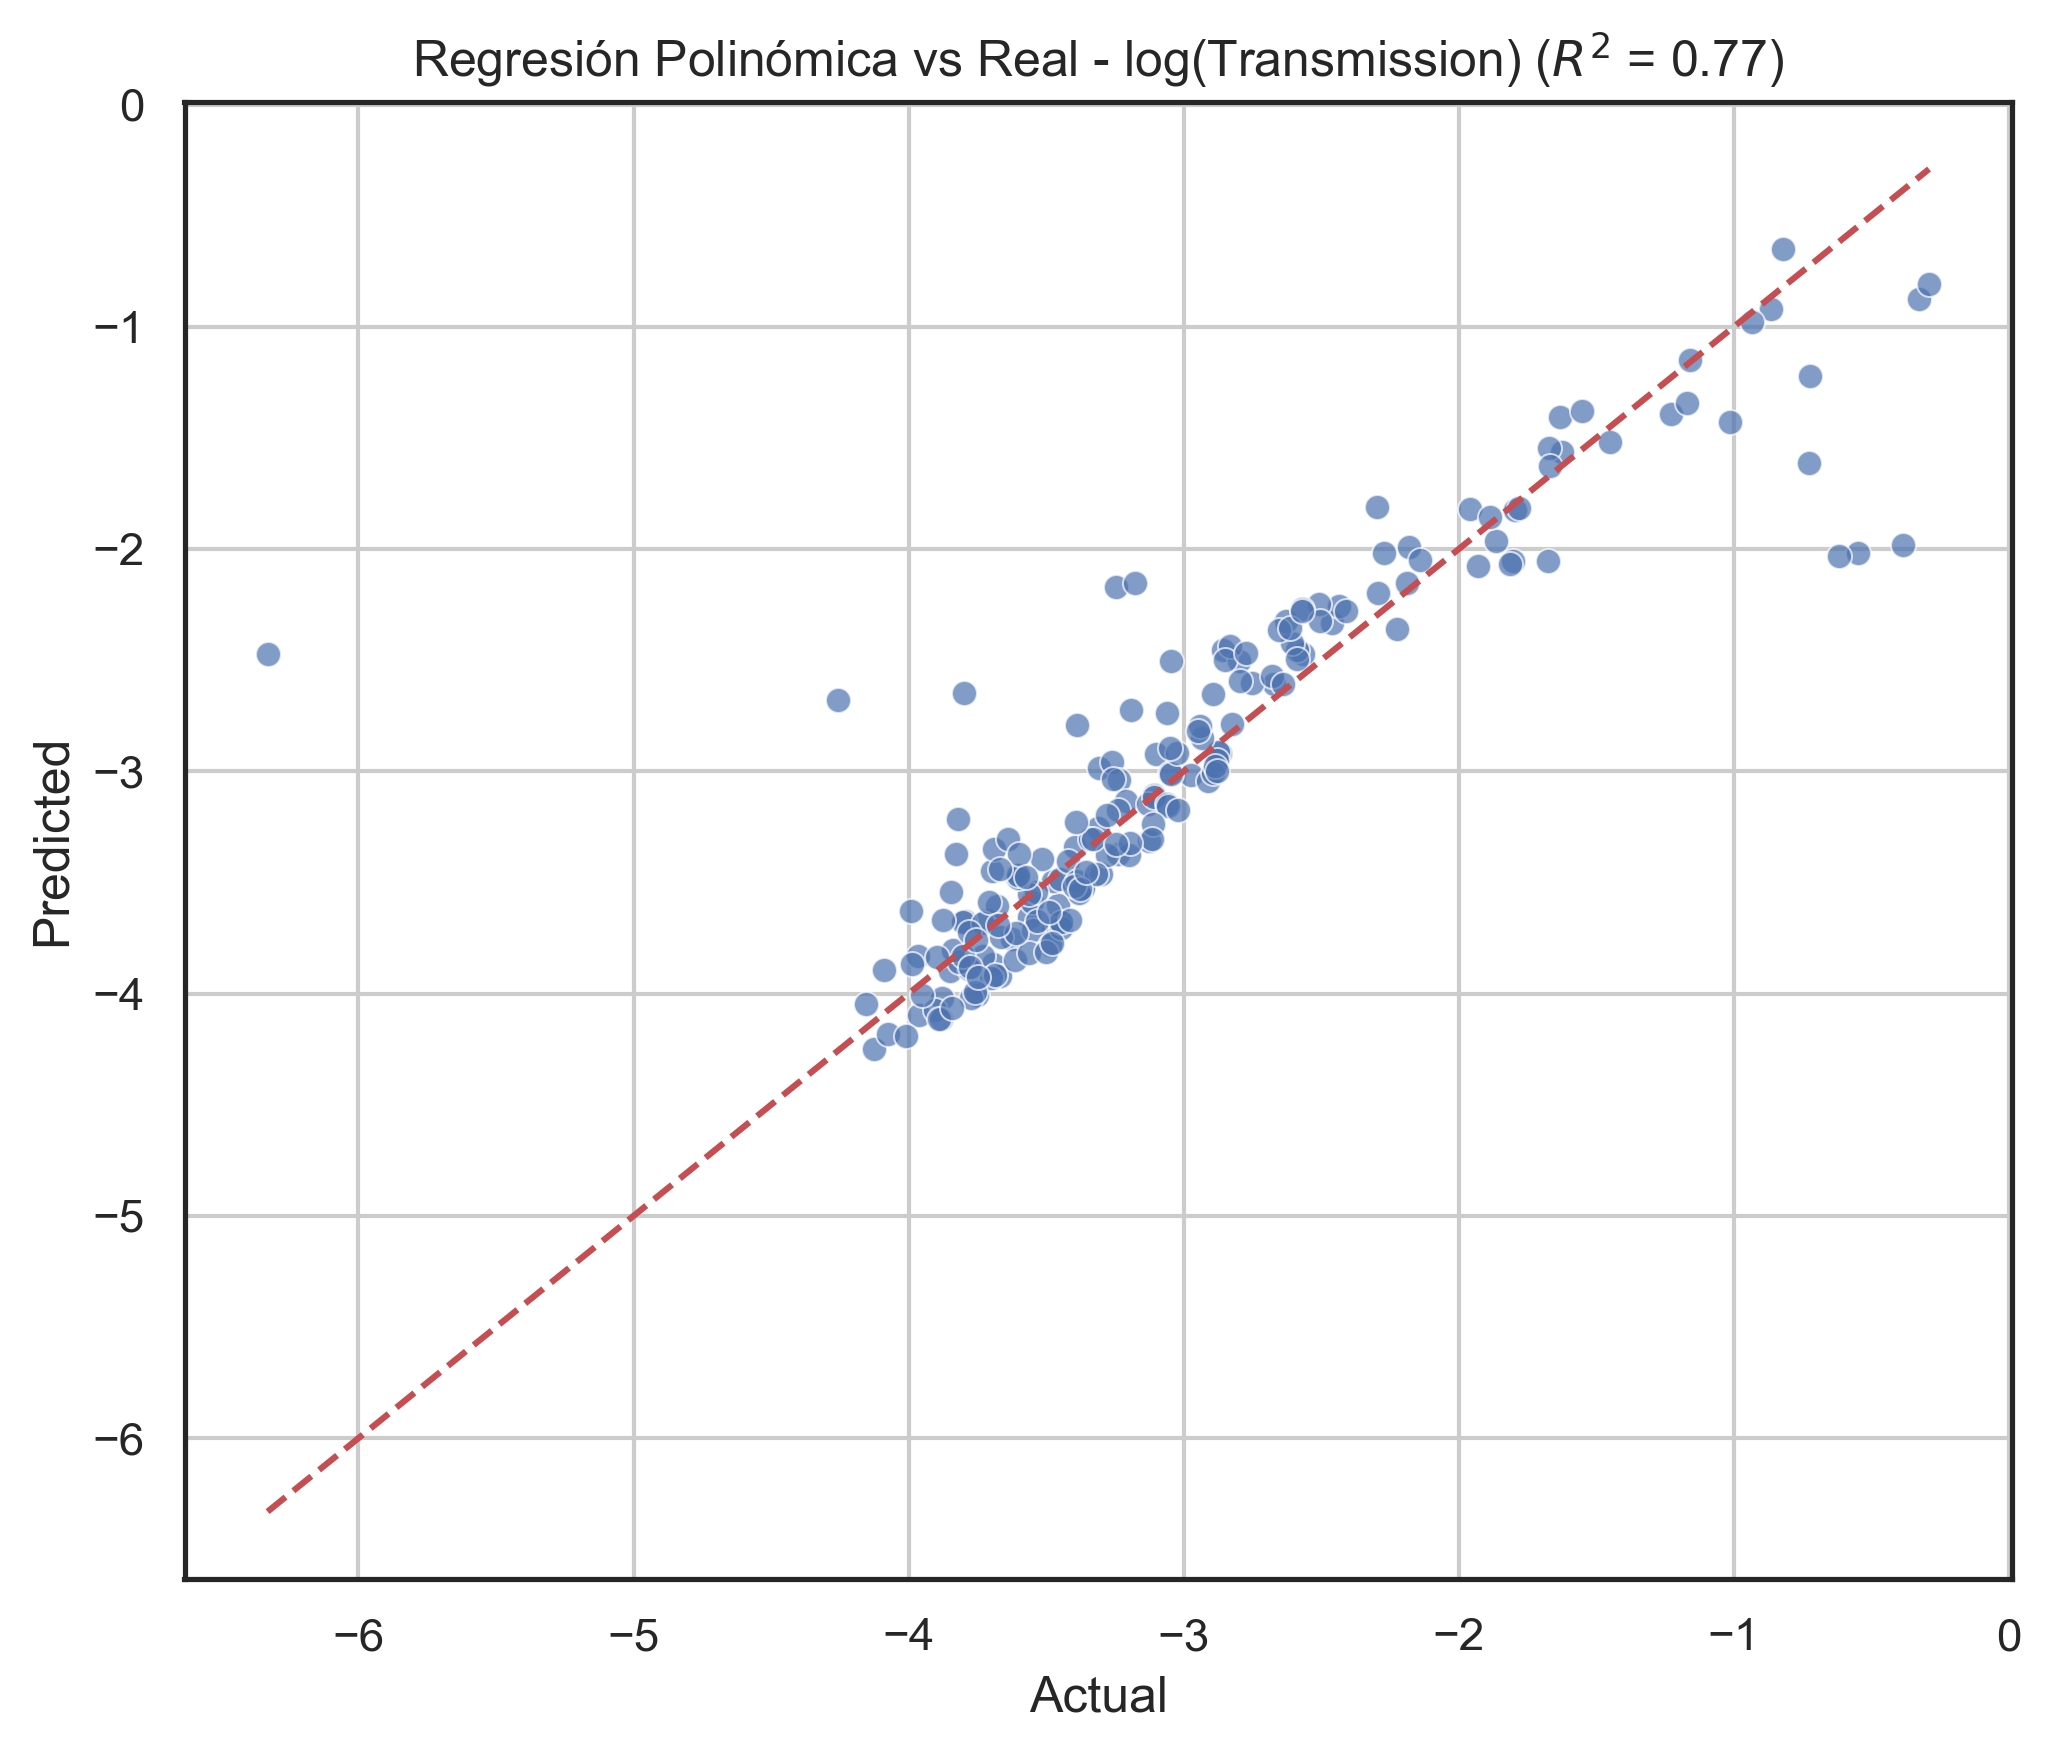

In [32]:
plot_prediction(y_T_test, y_pred_poly, f"Regresión Polinómica vs Real - log(Transmission) ($R^2$ = {r2_poly:.2f})")


In [33]:
feature_names = poly.get_feature_names_out(X.columns)
coefs = reg_poly.coef_
intercept = reg_poly.intercept_

# Mostrar como ecuación
print("Fórmula aproximada:\n")
equation = f"{intercept:.4f}"
for name, coef in zip(feature_names, coefs):
    equation += f" + ({coef:.4f})*{name}"
print("log(Transmission) ≈", equation)


Fórmula aproximada:

log(Transmission) ≈ -3.4819 + (0.1771)*$M_s$ + (0.8481)*$sin(U_\theta)$ + (0.2773)*$sin(U_\phi)$ + (0.0068)*$M_s$^2 + (0.2231)*$M_s$ $sin(U_\theta)$ + (0.1080)*$M_s$ $sin(U_\phi)$ + (0.3777)*$sin(U_\theta)$^2 + (0.0223)*$sin(U_\theta)$ $sin(U_\phi)$ + (0.0970)*$sin(U_\phi)$^2


In [22]:

# ====================================================
# 1. Añadir log(Transmission) como variable explicativa
# ====================================================
# Usamos las predicciones de log(Transmission) de test
X_train_phase = np.hstack([X_train_scaled, y_T_train.values.reshape(-1, 1)])
X_test_phase = np.hstack([X_test_scaled, y_pred_T.reshape(-1, 1)])

# ====================================================
# 2. Generar variables polinómicas para Phase Shift
# ====================================================
poly_phase = PolynomialFeatures(degree=2, include_bias=False)
X_poly_phase_train = poly_phase.fit_transform(X_train_phase)
X_poly_phase_test = poly_phase.transform(X_test_phase)

# ====================================================
# 3. Ajustar modelo de regresión
# ====================================================
reg_poly_phase = LinearRegression()
reg_poly_phase.fit(X_poly_phase_train, y_P_train)

# ====================================================
# 4. Predecir y evaluar
# ====================================================
y_pred_poly_phase = reg_poly_phase.predict(X_poly_phase_test)
r2_poly_phase = r2_score(y_P_test, y_pred_poly_phase)
print(f"R² regresión polinómica (Phase Shift): {r2_poly_phase:.3f}")

R² regresión polinómica (Phase Shift): 0.914


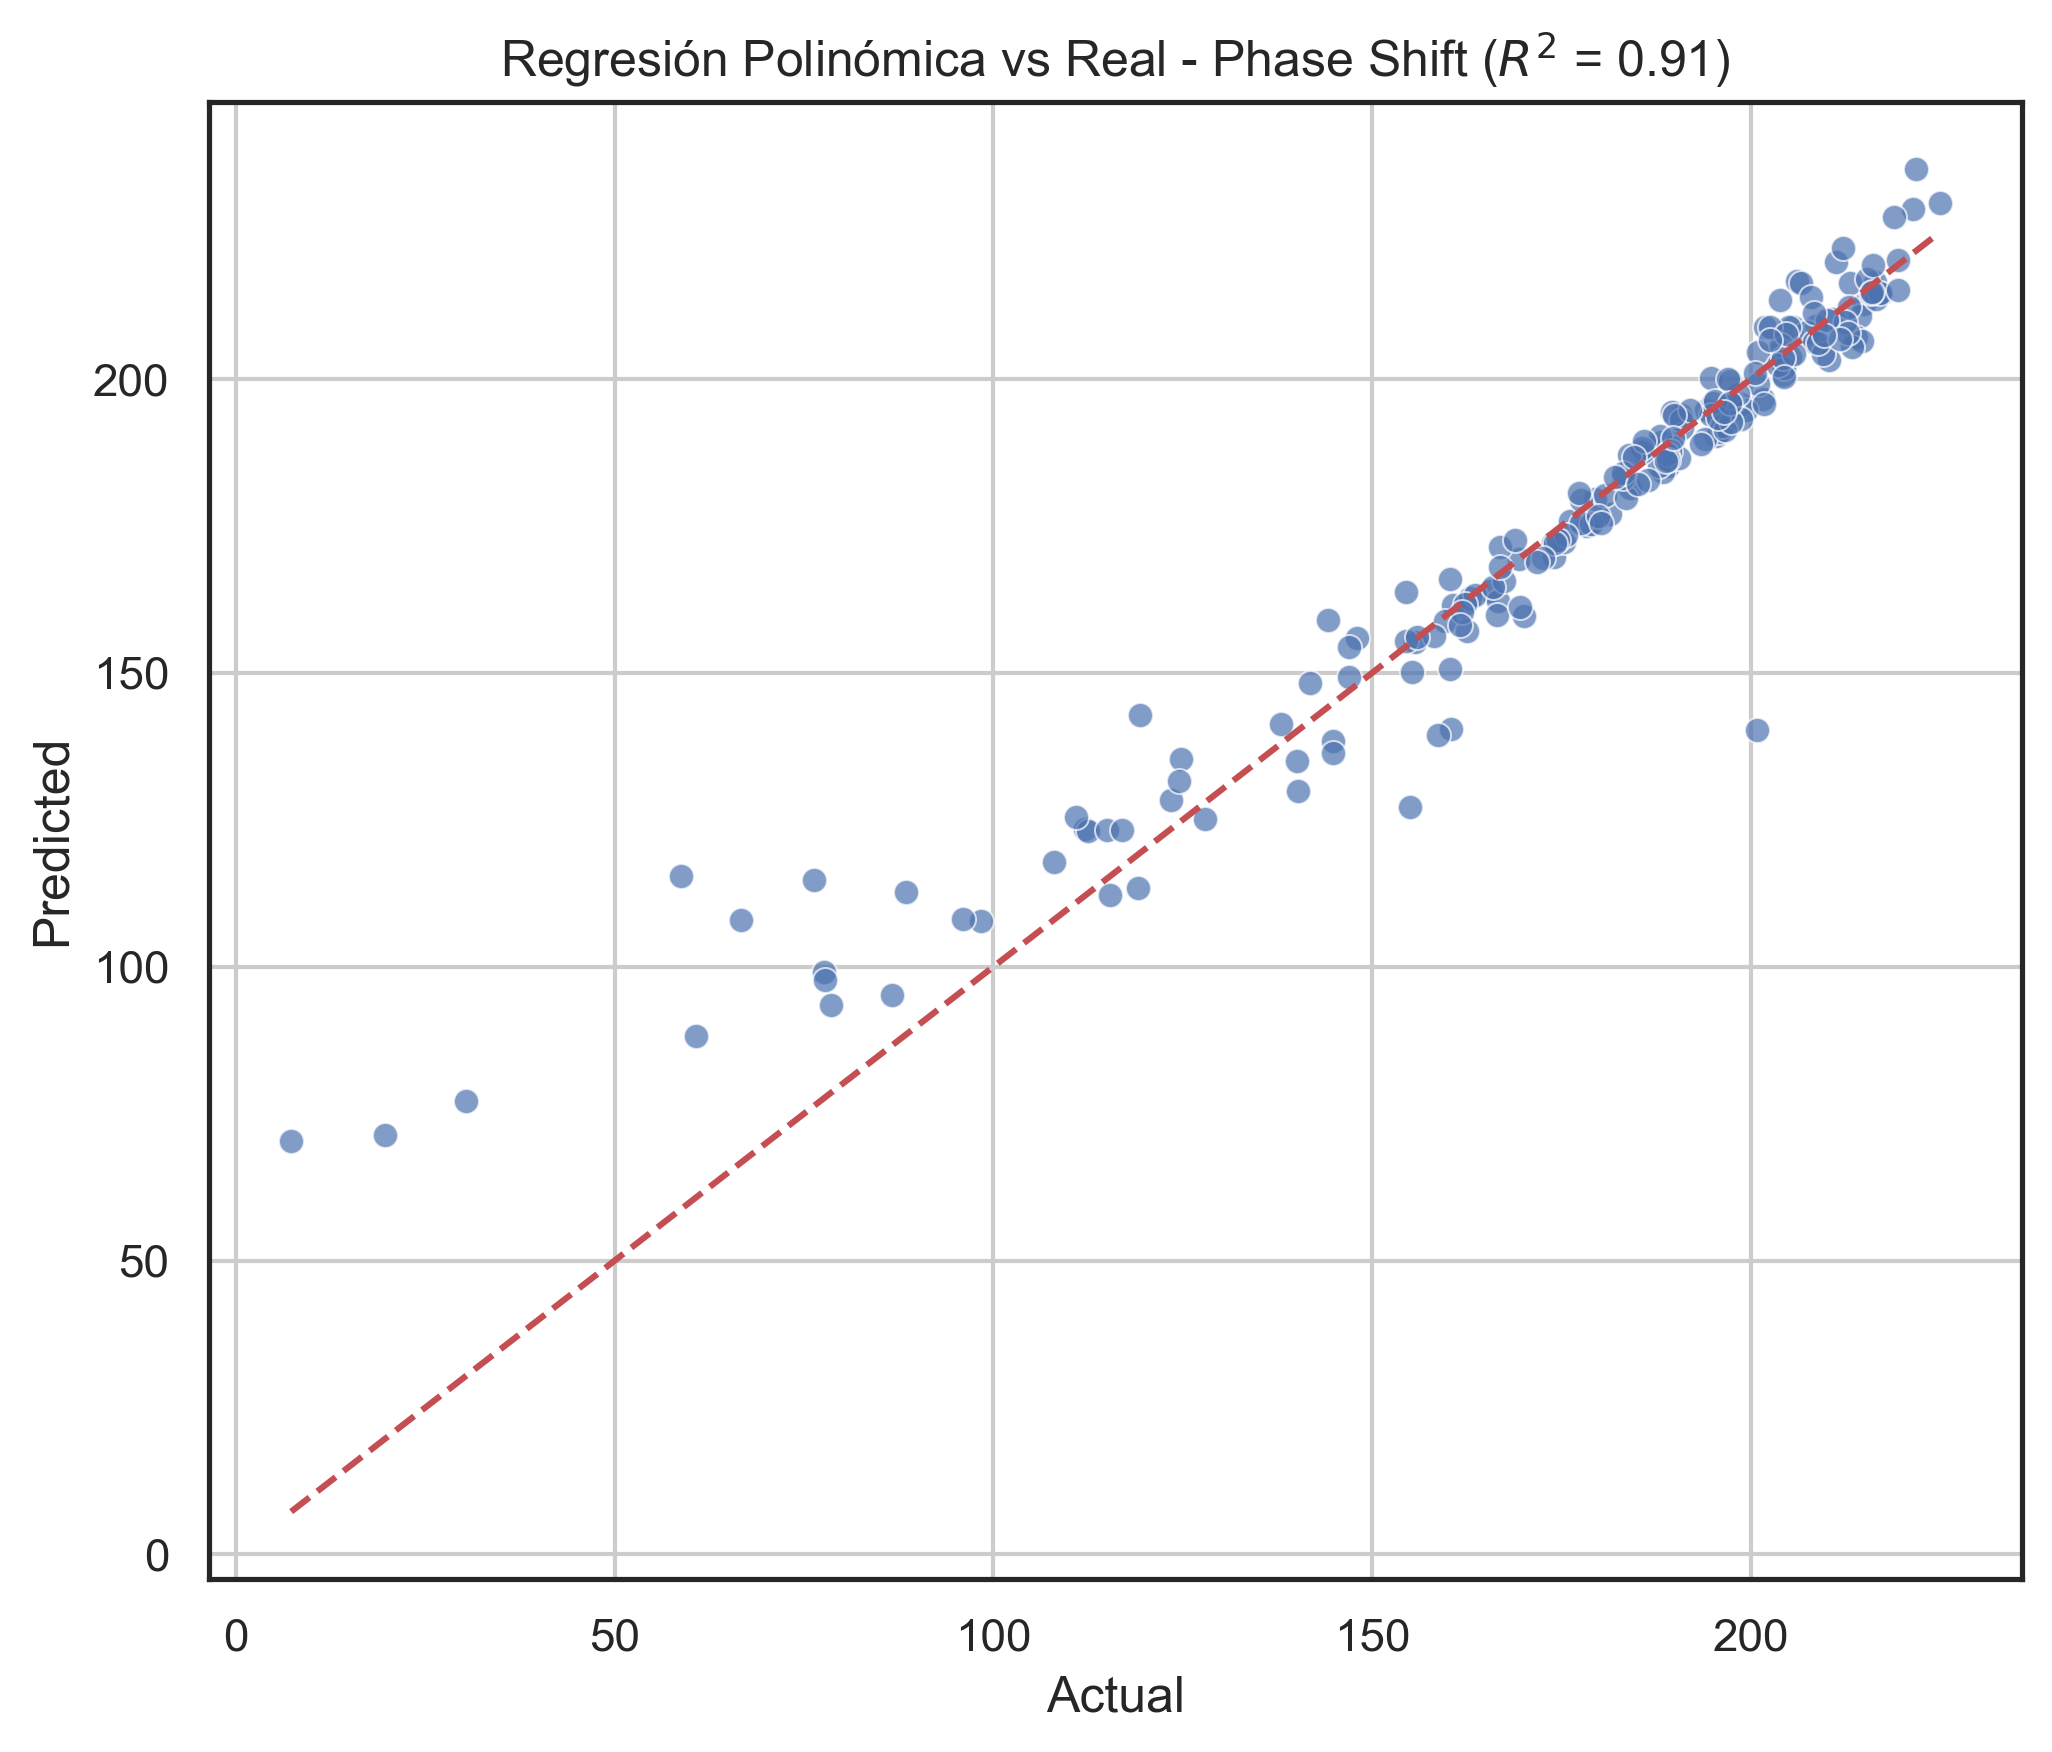

In [23]:
plot_prediction(y_P_test, y_pred_poly_phase, f"Regresión Polinómica vs Real - Phase Shift ($R^2$ = {r2_poly_phase:.2f})")


In [24]:
# Nombres de las variables, incluyendo Transmission como la última
feature_names_phase = list(X.columns) + ["log(Transmission)"]
feature_names_poly_phase = poly_phase.get_feature_names_out(feature_names_phase)

coefs_phase = reg_poly_phase.coef_
intercept_phase = reg_poly_phase.intercept_

# Construcción de la fórmula
print("Fórmula aproximada para Phase Shift:\n")
equation_phase = f"{intercept_phase:.4f}"
for name, coef in zip(feature_names_poly_phase, coefs_phase):
    equation_phase += f" + ({coef:.4f})*{name}"
print("Phase Shift ≈", equation_phase)


Fórmula aproximada para Phase Shift:

Phase Shift ≈ 183.9305 + (-0.0972)*$M_s$ + (-103.6965)*$sin(U_\theta)$ + (-8.6728)*$sin(U_\phi)$ + (-23.2628)*log(Transmission) + (3.7282)*$M_s$^2 + (-10.5624)*$M_s$ $sin(U_\theta)$ + (-4.5140)*$M_s$ $sin(U_\phi)$ + (2.6382)*$M_s$ log(Transmission) + (0.4247)*$sin(U_\theta)$^2 + (4.5334)*$sin(U_\theta)$ $sin(U_\phi)$ + (-20.8218)*$sin(U_\theta)$ log(Transmission) + (1.9262)*$sin(U_\phi)$^2 + (-2.0879)*$sin(U_\phi)$ log(Transmission) + (-7.2335)*log(Transmission)^2


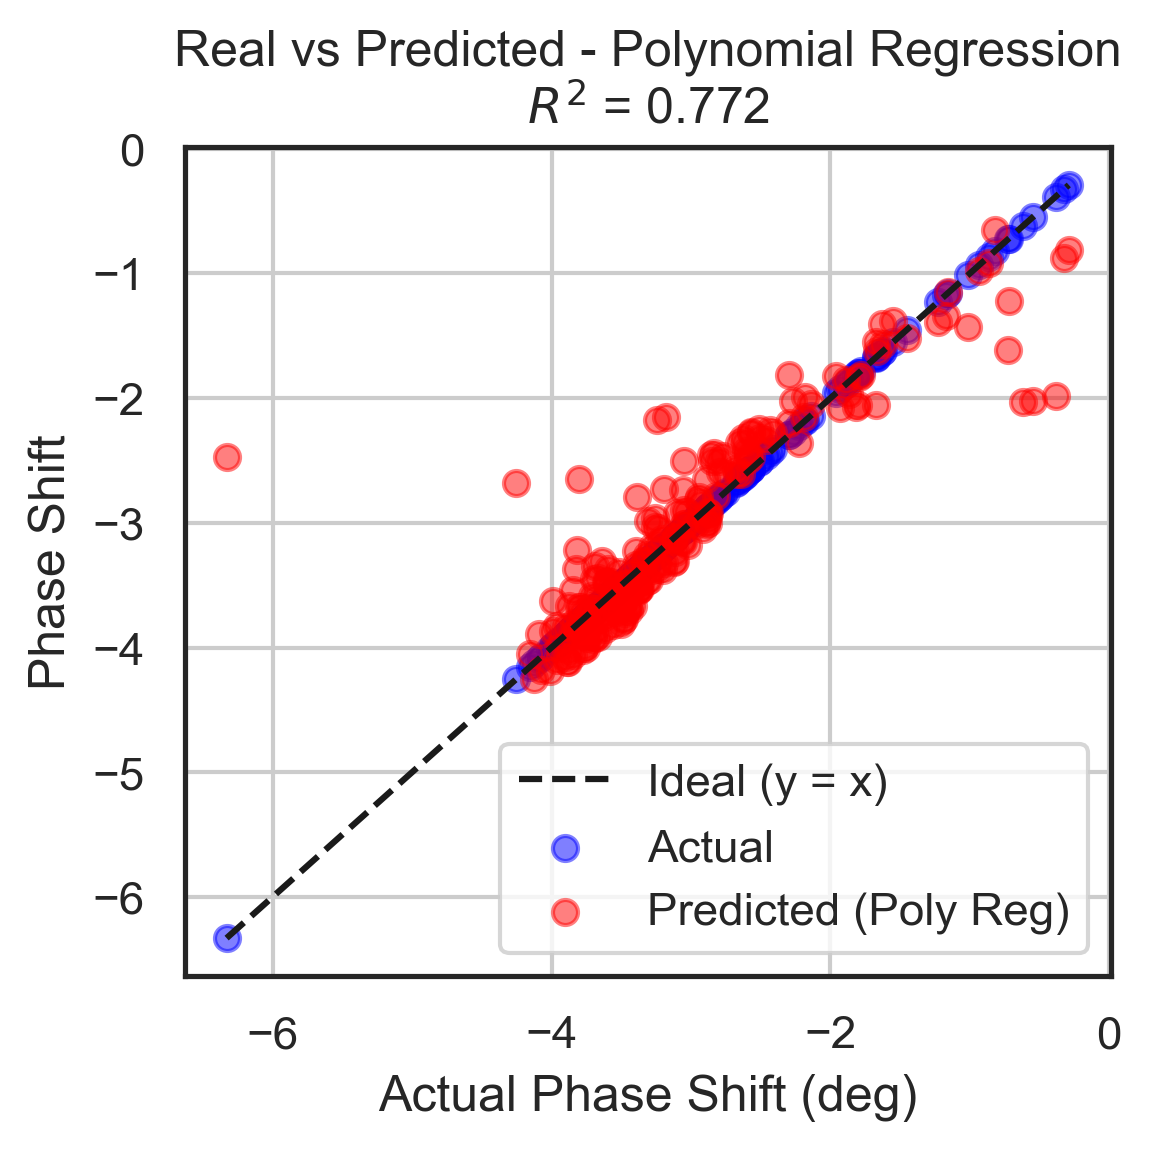

In [37]:
plt.figure(figsize=(4,4))

# Línea ideal
plt.plot([y_T_test.min(), y_T_test.max()], [y_T_test.min(), y_T_test.max()], 'k--', label="Ideal (y = x)")

# Reales
plt.scatter(y_T_test, y_T_test, color='blue', alpha=0.5, label='Actual')

# Predichos
plt.scatter(y_T_test, y_pred_poly, color='red', alpha=0.5, label='Predicted (Poly Reg)')

plt.xlabel("Actual Phase Shift (deg)")
plt.ylabel("Phase Shift")
plt.title(f"Real vs Predicted - Polynomial Regression\n$R^2$ = {r2_poly:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

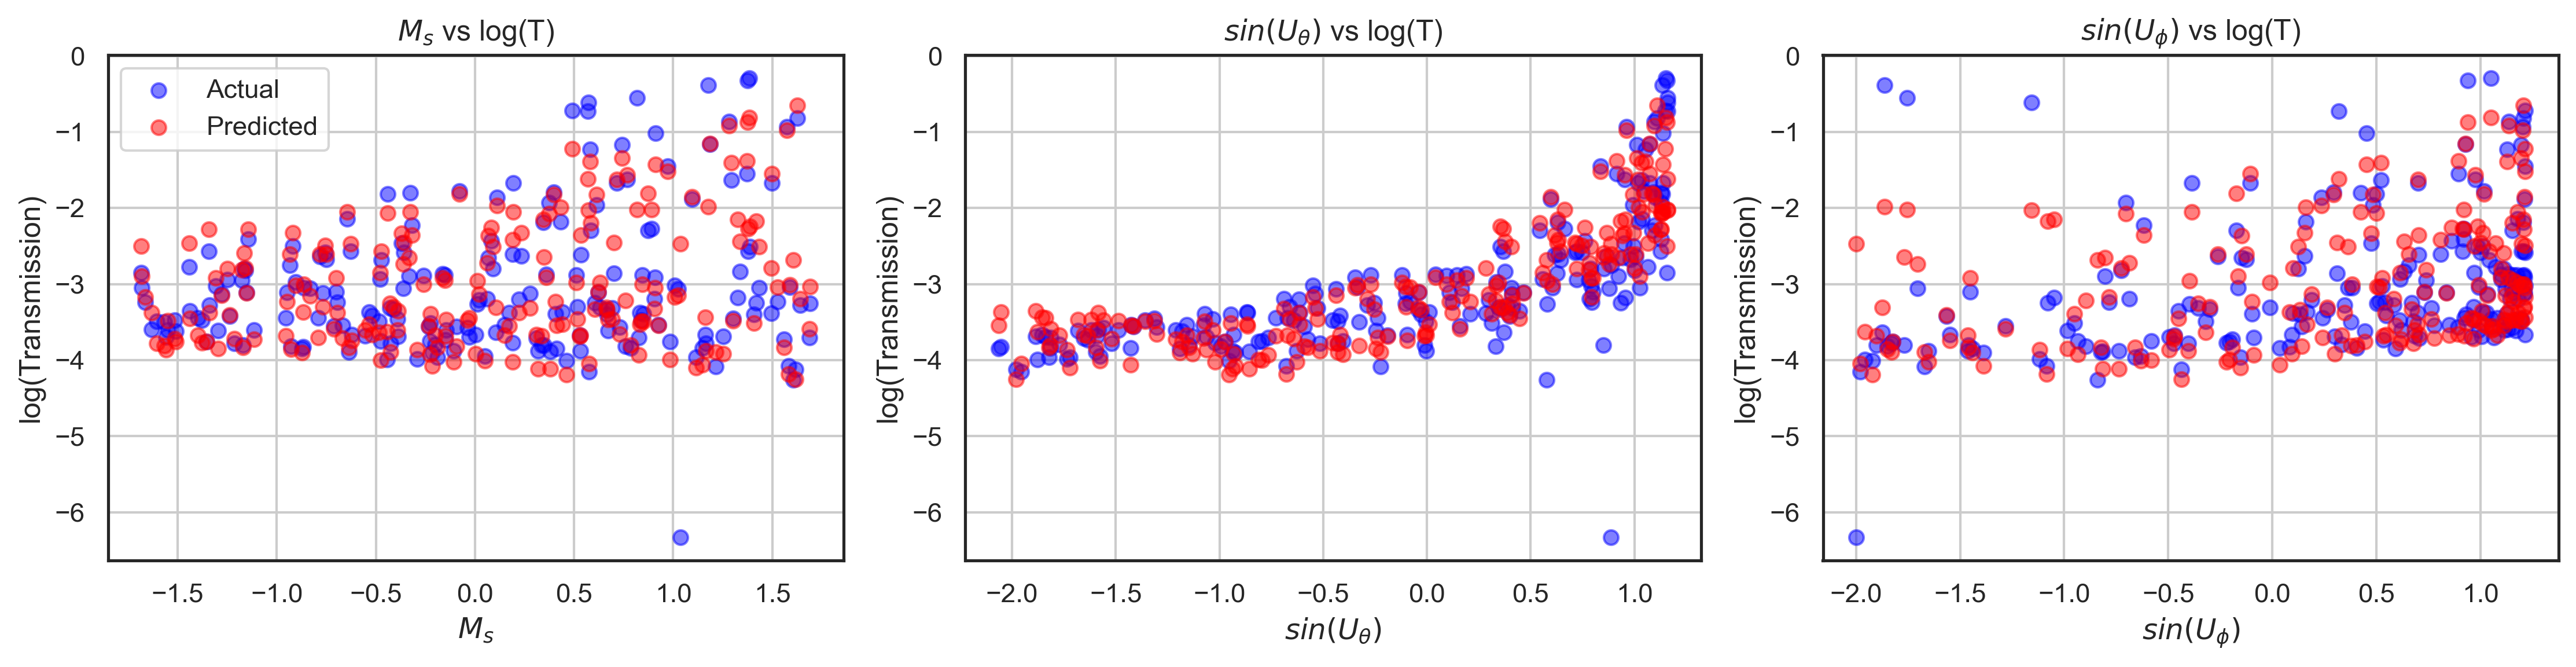

In [26]:
# Asegúrate de tener nombres de variables (sin incluir log(Transmission) si ya lo tienes como input adicional)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

n_vars = len(X_test_df.columns)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(X_test_df.columns):
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(X_test_df[col], y_T_test, alpha=0.5, label="Actual", color='blue')
    plt.scatter(X_test_df[col], y_pred_poly, alpha=0.5, label="Predicted", color='red')
    plt.xlabel(col)
    plt.ylabel("log(Transmission)")
    plt.title(f"{col} vs log(T)")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

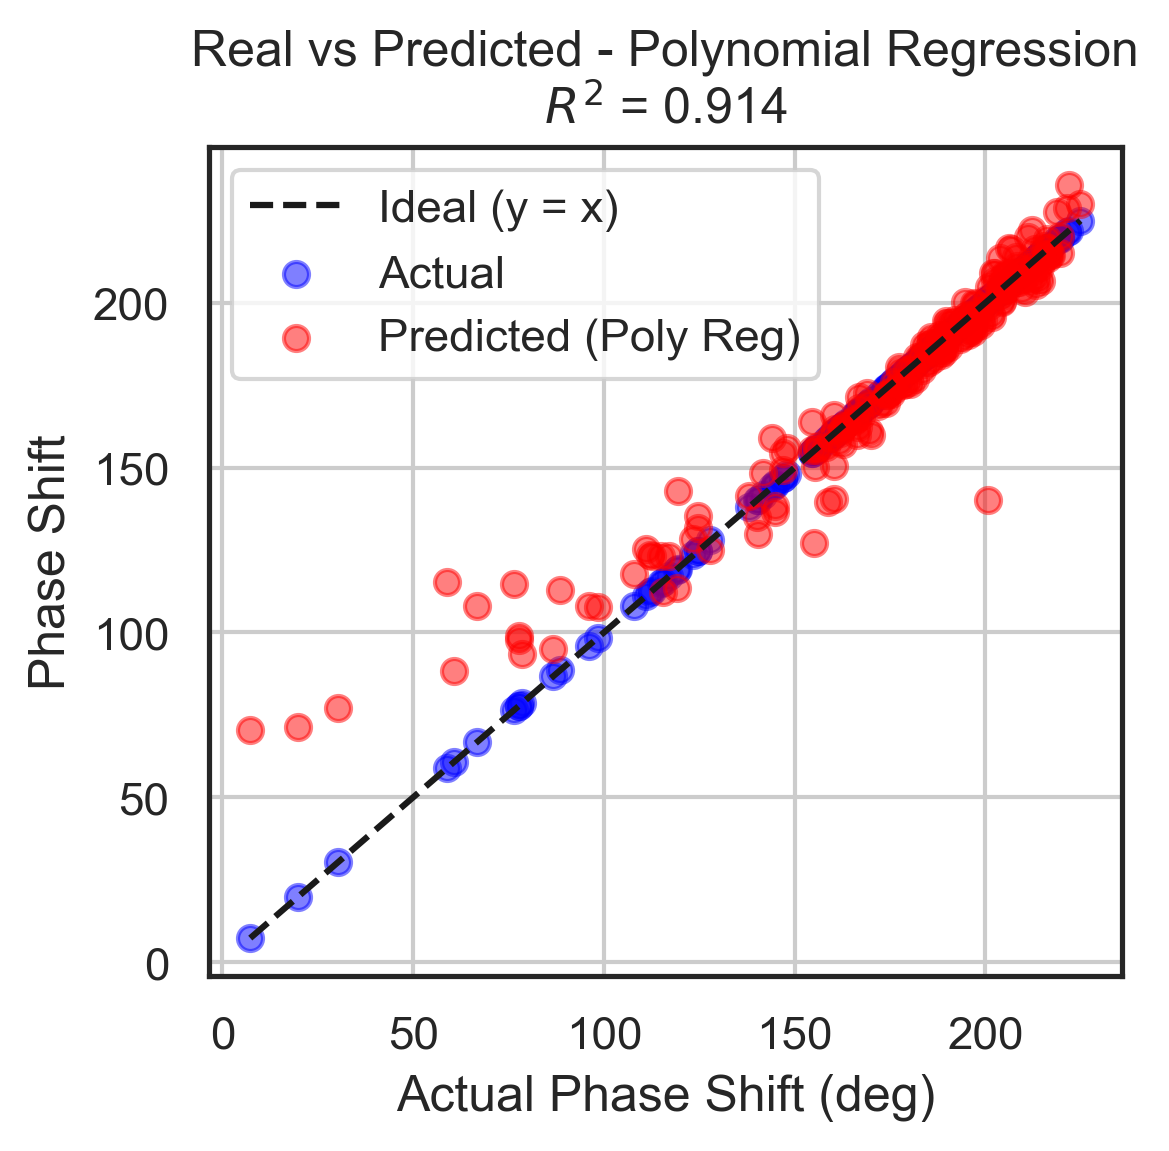

In [27]:
plt.figure(figsize=(4,4))

# Línea ideal
plt.plot([y_P_test.min(), y_P_test.max()], [y_P_test.min(), y_P_test.max()], 'k--', label="Ideal (y = x)")

# Reales
plt.scatter(y_P_test, y_P_test, color='blue', alpha=0.5, label='Actual')

# Predichos
plt.scatter(y_P_test, y_pred_poly_phase, color='red', alpha=0.5, label='Predicted (Poly Reg)')

plt.xlabel("Actual Phase Shift (deg)")
plt.ylabel("Phase Shift")
plt.title(f"Real vs Predicted - Polynomial Regression\n$R^2$ = {r2_poly_phase:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


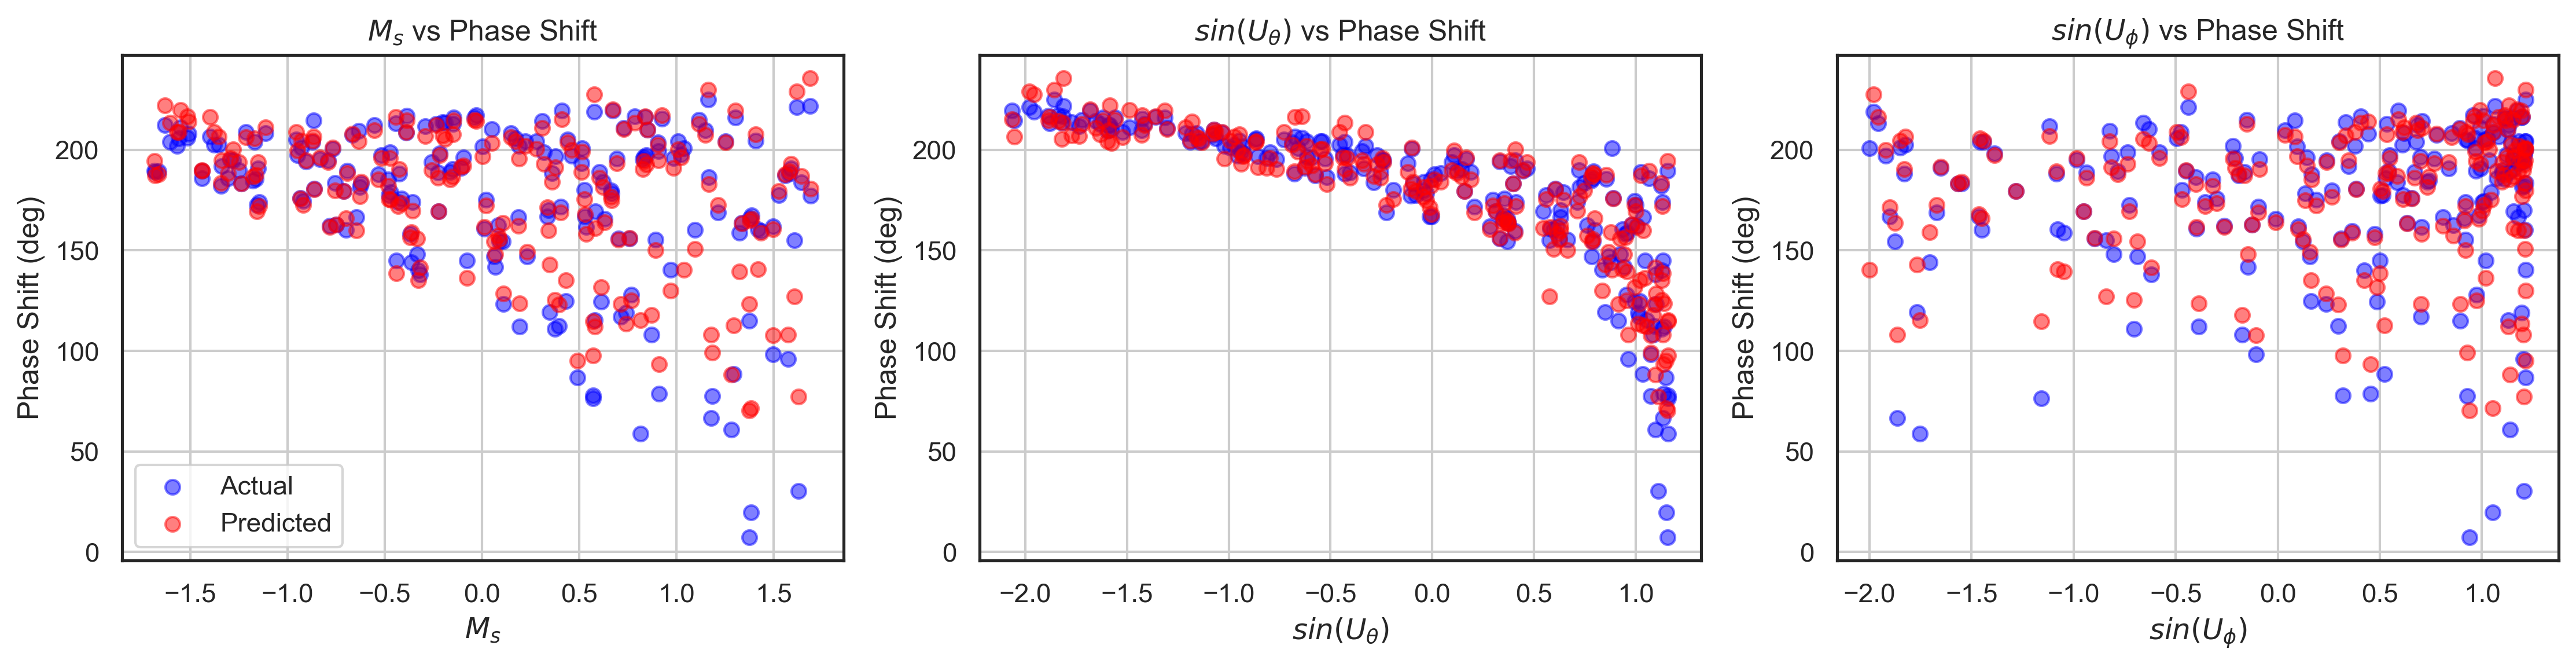

In [28]:

# Asegúrate de tener nombres de variables (sin incluir log(Transmission) si ya lo tienes como input adicional)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

n_vars = len(X_test_df.columns)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(X_test_df.columns):
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(X_test_df[col], y_P_test, alpha=0.5, label="Actual", color='blue')
    plt.scatter(X_test_df[col], y_pred_poly_phase, alpha=0.5, label="Predicted", color='red')
    plt.xlabel(col)
    plt.ylabel("Phase Shift (deg)")
    plt.title(f"{col} vs Phase Shift")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()
